<a href="https://colab.research.google.com/github/rtajeong/M2_2025/blob/main/gg_18_Statistical_Analysis_House_Price_Prediction_rev6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 통계적 분석

- 상관관계가 큰 변수 찾기
- 결측치 처리
- 이상치 처리
- 로그 변환

- 데이터 (주택가격 예측 데이터)
  - 아래 캐글 데이터를 다운받는다.
  https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
df_train = pd.read_csv('train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 특성값 설명
- see https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [5]:
df_train.shape

(1460, 81)

## Target (목적변수) 의 특성 파악

### Distribution of the target variable

In [6]:
# 목적 변수의 통계적 특성
df_train['SalePrice'].describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


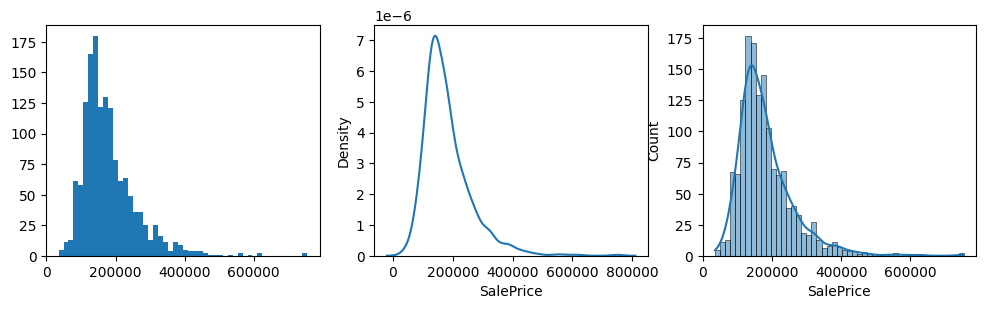

In [7]:
# different ways to explore data distributions
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.hist(df_train['SalePrice'], bins=50)

plt.subplot(1,3,2)
sns.kdeplot(df_train['SalePrice'])

plt.subplot(1,3,3)
sns.histplot(df_train['SalePrice'], kde=True); # kde - kernel density estimation

plt.show()

- 다음과 같은 특성을 발견할 수 있다.

  - Deviate from the normal distribution
  - Have appreciable positive skewness
  - Show peakedness

### skewness and kurtosis
- 왜도(skewness, 또는 비대칭도): 분포의 대칭 정도를 나타냄 (+:왼쪽 치우침, -:오른쪽 치우침)
- 첨도(kurtosis): 정규분포 대비 상대적인 뾰족한 정도(?)를 나타냄 (정규분포는 0),
  - 확률분포의 꼬리(tail)가 얼마나 두껍거나 얇은지를 나타내는 통계적 척도입니다. 즉, 데이터가 평균 주변에 얼마나 뾰족하게 몰려 있는지, 혹은 극단값(outlier)이 얼마나 자주 발생하는지를 보여
  - 첨도값(K)이 0에 가까우면 산포도가 정규분포에 가깝다.
  - 꼬리 모양의 분포 정보 제공 (정규분포 대비) - 데이터에 이상값이나 극단값이 존재할 가능성을 이해하려는 상황에서 특히 유용
  - in fact, df.kurtosis() returns an exess kurtosis (0 for normal distribution) for comparison with normal distribution
- 두 특성이 너무 문제가 되면 데이터 변환 실행 (Log, sqaure, square root, inverse, etc.)


In [8]:
# skewness and kurtosis (kurto'sis)
print("Skewness: {:f}".format(df_train['SalePrice'].skew()))
print("Kurtosis: {:f}".format(df_train['SalePrice'].kurt()))

Skewness: 1.882876
Kurtosis: 6.536282


<Axes: xlabel='SalePrice', ylabel='Count'>

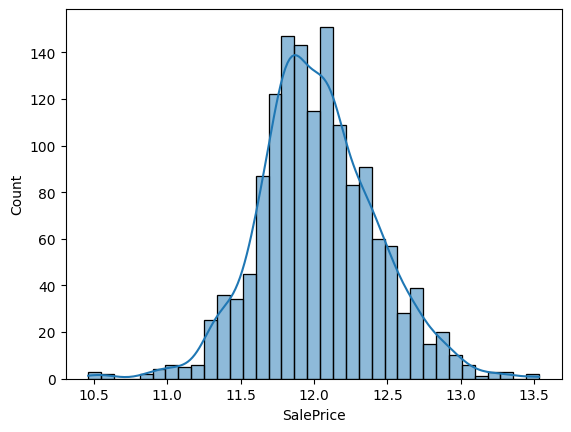

In [10]:
sns.histplot(np.log1p(df_train['SalePrice']), kde=True)  # log-normal dist

In [11]:
print("Skewness: {:f}".format(np.log(df_train['SalePrice'].skew())))
print("Kurtosis: {:f}".format(np.log(df_train['SalePrice'].kurt())))

Skewness: 0.632800
Kurtosis: 1.877368


## 목적변수와의 연관성
- 변수들간의 상관 관계는 correlation (상관관계) 을 보면 알 수 있다.
- 상관관계를 보기 전에 먼저 target 과 특정 변수와의 관계를 보고 싶다면...

### 산포도 (scatter plot)

In [17]:
# 산포도를 통해 grlivarea 와 saleprice 의 관계를 보자
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.head(2)

,SalePrice,GrLivArea
0,208500,1710
1,181500,1262


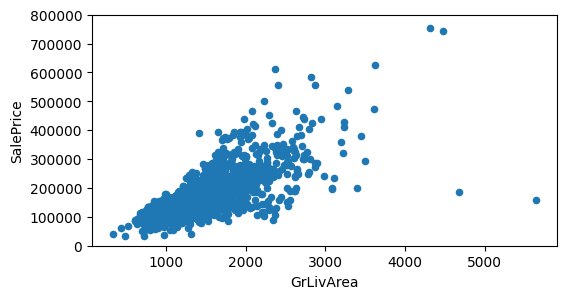

In [19]:
data.plot(x=var, y='SalePrice', kind='scatter', ylim=(0,800000), figsize=(6,3));

In [ ]:
# plt.scatter 로도 그릴 수 있다.
# data[var].shape, data.SalePrice.shape
# plt.scatter(data[var], data.SalePrice);

In [20]:
df_train['GrLivArea'].sort_values(ascending=False).head()

,GrLivArea
1298,5642
523,4676
1182,4476
691,4316
1169,3627


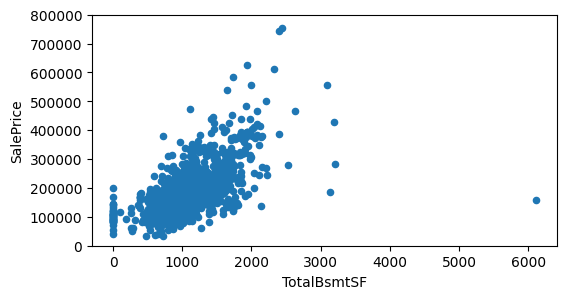

In [21]:
# scatter plot for TotalBsmtSF and SalePrice
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), figsize=(6,3));

In [22]:
df_train['TotalBsmtSF'].sort_values(ascending=False).head()

,TotalBsmtSF
1298,6110
332,3206
496,3200
523,3138
440,3094


### 카테고리 변수와의 관계: 박스플롯으로 보면 편리

In [23]:
print(df_train.shape)
print(df_train['OverallQual'].unique())
print(set(df_train['OverallQual']))
df_train['OverallQual'].value_counts()

(1460, 81)
[ 7  6  8  5  9  4 10  3  1  2]
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}


,count
OverallQual,
5,397
6,374
7,319
8,168
4,116
9,43
3,20
10,18
2,3


In [24]:
print(df_train['GarageCars'].unique())
df_train['GarageCars'].value_counts()

[2 3 1 0 4]


,count
GarageCars,
2,824
1,369
3,181
0,81
4,5


In [25]:
# 박스플롯 overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.head(2)

,SalePrice,OverallQual
0,208500,7
1,181500,6


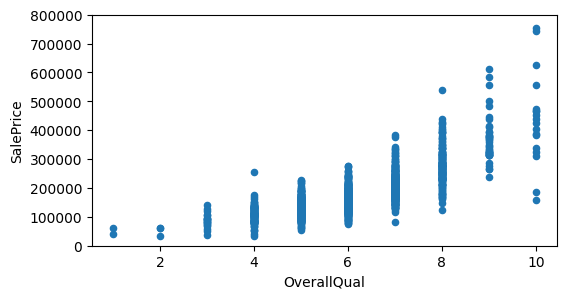

In [26]:
data.plot(kind='scatter', x=var, y='SalePrice', ylim=(0,800000), figsize=(6,3));

- scatter plot 보다는 boxplot 으로 보는 게 좋을 듯...
  - df.polt.box() 도 있지만 받아들이는 데이터의 형태가 다름 (dataframe manual 참고)

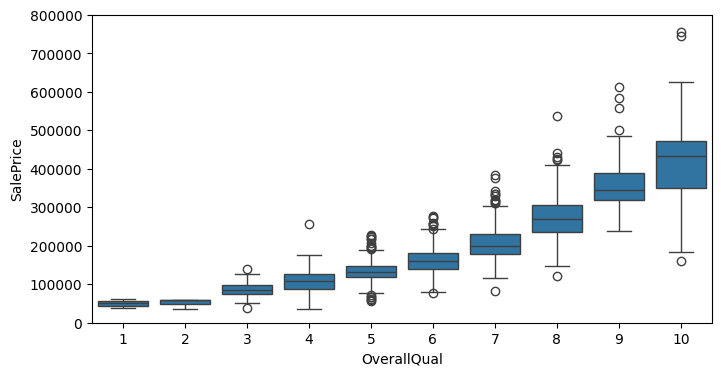

In [27]:
# f, ax = plt.subplots(figsize=(8, 6))
plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

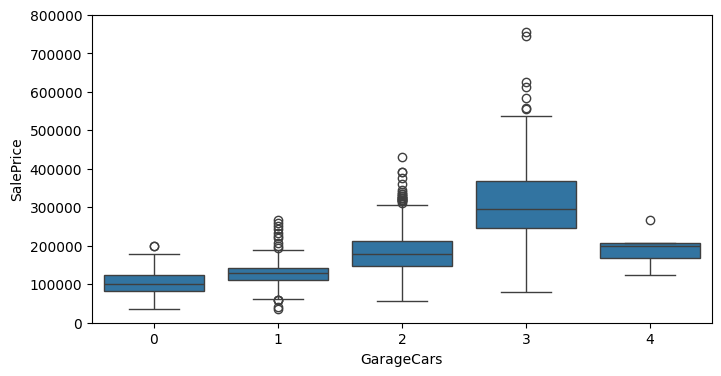

In [30]:
var = 'GarageCars'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1) # axis=0 은 위아래로 추가.
plt.figure(figsize=(8, 4))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

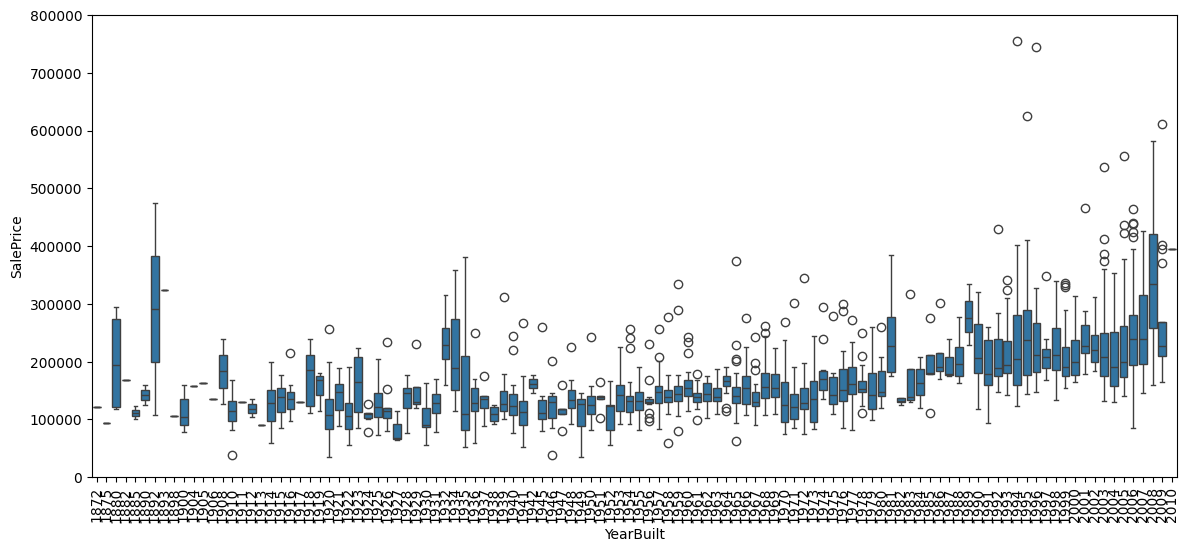

In [ ]:
var = 'YearBuilt'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

- 약한 관련성이 있으며 최근의 주택 가격이 높다. 인플레이션이 반영된 가격일 수도 있다.
유용한 특성을 선택하는 것이 문제이다. 이러한 특성 선택을 임의로 주관적으로 수행하는 것은 한계가 있다. 객관적인 방법이 필요하다.

### 객관적으로 판단하는 방법으로는...
- Correlation matrix (heatmap style).
- 'SalePrice' correlation matrix (zoomed heatmap style).
- Scatter plots between the most correlated variables

In [31]:
df_train.dtypes, df_train.shape

(Id                 int64
 MSSubClass         int64
 MSZoning          object
 LotFrontage      float64
 LotArea            int64
                   ...   
 MoSold             int64
 YrSold             int64
 SaleType          object
 SaleCondition     object
 SalePrice          int64
 Length: 81, dtype: object,
 (1460, 81))

In [32]:
len(df_train.dtypes[df_train.dtypes != 'object'])   # no. of numerical features

38

In [33]:
len(df_train.dtypes[df_train.dtypes == 'object'])

43

In [34]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [35]:
df_train.dtypes[df_train.dtypes == 'object'].head()  # categorical columns

,0
MSZoning,object
Street,object
Alley,object
LotShape,object
LandContour,object


In [36]:
df_train.dtypes[df_train.dtypes != 'object'].head()  # numerial columns

,0
Id,int64
MSSubClass,int64
LotFrontage,float64
LotArea,int64
OverallQual,int64


## 특성 구분 (숫자형, 범주형)

In [37]:
categorical_cols = df_train.dtypes[df_train.dtypes == 'object'].index
numerical_cols = df_train.dtypes[df_train.dtypes != 'object'].index
len(categorical_cols), categorical_cols, len(numerical_cols), numerical_cols

(43,
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
        'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
        'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition'],
       dtype='object'),
 38,
 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
        'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
        'H

(38, 38)


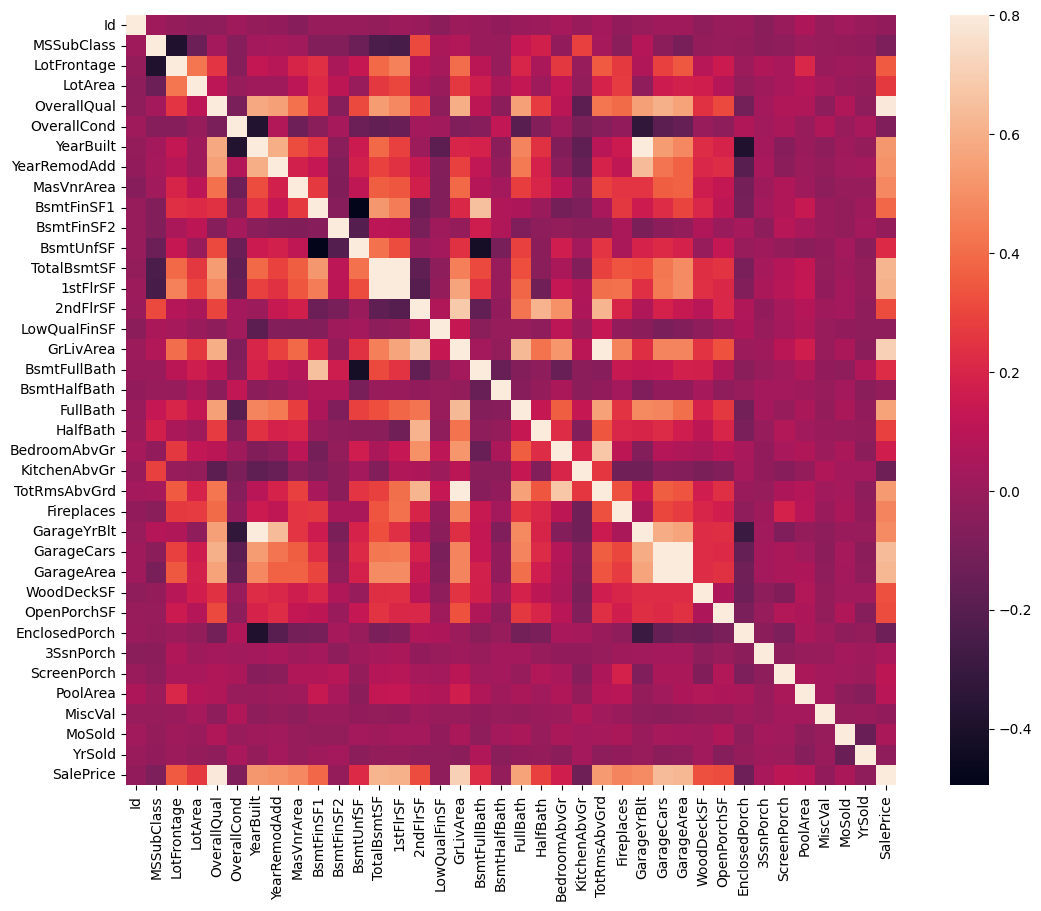

In [38]:
## correlation matrix for numerical columns

corrmat = df_train[numerical_cols].corr()
print(corrmat.shape)
f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(corrmat, vmax=.8, square=True);

In [39]:
corrmat

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


히트맵 타입의 상관관계 지도는 유용하다. 그림을 보면 'TotalBsmtSF', '1stFlrSF', 'GarageX' 등의 상관관계가 큰 것을 알 수 있다. 경우에 따라서는 두개의 특성이 거의 동일한 정보를 포함하는 것도 있다.

가장 중요한 것은 'SalePrice'와의 상관관계이다. 이를 보면 'GrLivArea', 'TotalBsmtSF', 'OverallQual'가 관련이 많은 것을 알 수 있다. 다른 특성들도 일부 관련이 있으므로 무시할 수 없다.

#### 'SalePrice' correlation matrix (zoomed heatmap style)

In [40]:
corrmat.head(6)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856


In [41]:
# df.nlargest(): Get the rows of a DataFrame sorted by the n largest values of columns. (numerical features)

k = 6      #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice'); cols

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
SalePrice,-0.021917,-0.084284,0.351799,0.263843,0.790982,-0.077856,0.522897,0.507101,0.477493,0.386420,...,0.324413,0.315856,-0.128578,0.044584,0.111447,0.092404,-0.021190,0.046432,-0.028923,1.000000
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
GrLivArea,0.008273,0.074853,0.402797,0.263116,0.593007,-0.079686,0.199010,0.287389,0.390857,0.208171,...,0.247433,0.330224,0.009113,0.020643,0.101510,0.170205,-0.002416,0.050240,-0.036526,0.708624
GarageCars,0.016570,-0.040110,0.285691,0.154871,0.600671,-0.185758,0.537850,0.420622,0.364204,0.224054,...,0.226342,0.213569,-0.151434,0.035765,0.050494,0.020934,-0.043080,0.040522,-0.039117,0.640409
GarageArea,0.017634,-0.098672,0.344997,0.180403,0.562022,-0.151521,0.478954,0.371600,0.373066,0.296970,...,0.224666,0.241435,-0.121777,0.035087,0.051412,0.061047,-0.027400,0.027974,-0.027378,0.623431
TotalBsmtSF,-0.015415,-0.238518,0.392075,0.260833,0.537808,-0.171098,0.391452,0.291066,0.363936,0.522396,...,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969,0.613581


In [42]:
cols = cols.index; cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF'],
      dtype='object')

In [ ]:
df_train[cols].corr()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF
SalePrice,1.000000,0.790982,0.708624,0.640409,0.623431,0.613581
OverallQual,0.790982,1.000000,0.593007,0.600671,0.562022,0.537808
GrLivArea,0.708624,0.593007,1.000000,0.467247,0.468997,0.454868
GarageCars,0.640409,0.600671,0.467247,1.000000,0.882475,0.434585
GarageArea,0.623431,0.562022,0.468997,0.882475,1.000000,0.486665
TotalBsmtSF,0.613581,0.537808,0.454868,0.434585,0.486665,1.000000


In [43]:
cm = df_train[cols].corr().values  # array
cm

array([[1.        , 0.7909816 , 0.70862448, 0.6404092 , 0.62343144,
        0.61358055],
       [0.7909816 , 1.        , 0.59300743, 0.60067072, 0.56202176,
        0.5378085 ],
       [0.70862448, 0.59300743, 1.        , 0.46724742, 0.46899748,
        0.4548682 ],
       [0.6404092 , 0.60067072, 0.46724742, 1.        , 0.88247541,
        0.43458483],
       [0.62343144, 0.56202176, 0.46899748, 0.88247541, 1.        ,
        0.48666546],
       [0.61358055, 0.5378085 , 0.4548682 , 0.43458483, 0.48666546,
        1.        ]])

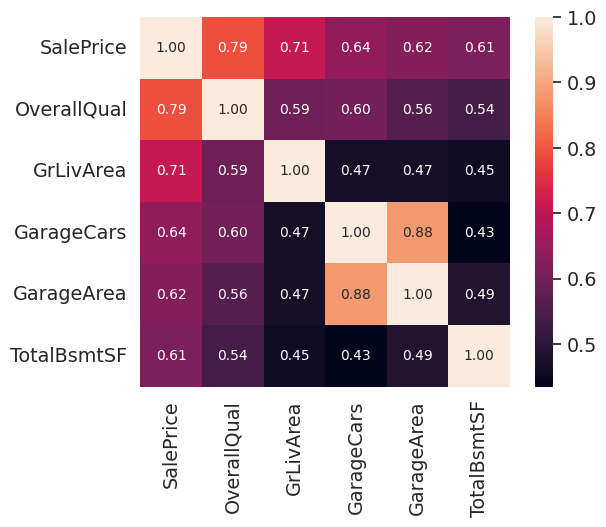

In [44]:
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
        fmt='.2f', annot_kws={'size': 10},
        yticklabels=cols.values, xticklabels=cols.values)
plt.show()

상관관계가 높은 순으로 정렬

* 'OverallQual', 'GrLivArea' and 'TotalBsmtSF'은 'SalePrice'와 상관관계가 크다.
* 'GarageCars' and 'GarageArea' 특성은 같은 의미를 갖는 것으로 보인다 (상관관계 0.88).
* 'TotalBsmtSF' and '1stFloor' 도 상관관계가 크다. (0.82)
* 'FullBath'?
* 'TotRmsAbvGrd' and 'GrLivArea' 도 상관관계가 크다(0.83).
* 'YearBuilt' 와 'GarageYearBuilt' 도 높은 상관관계

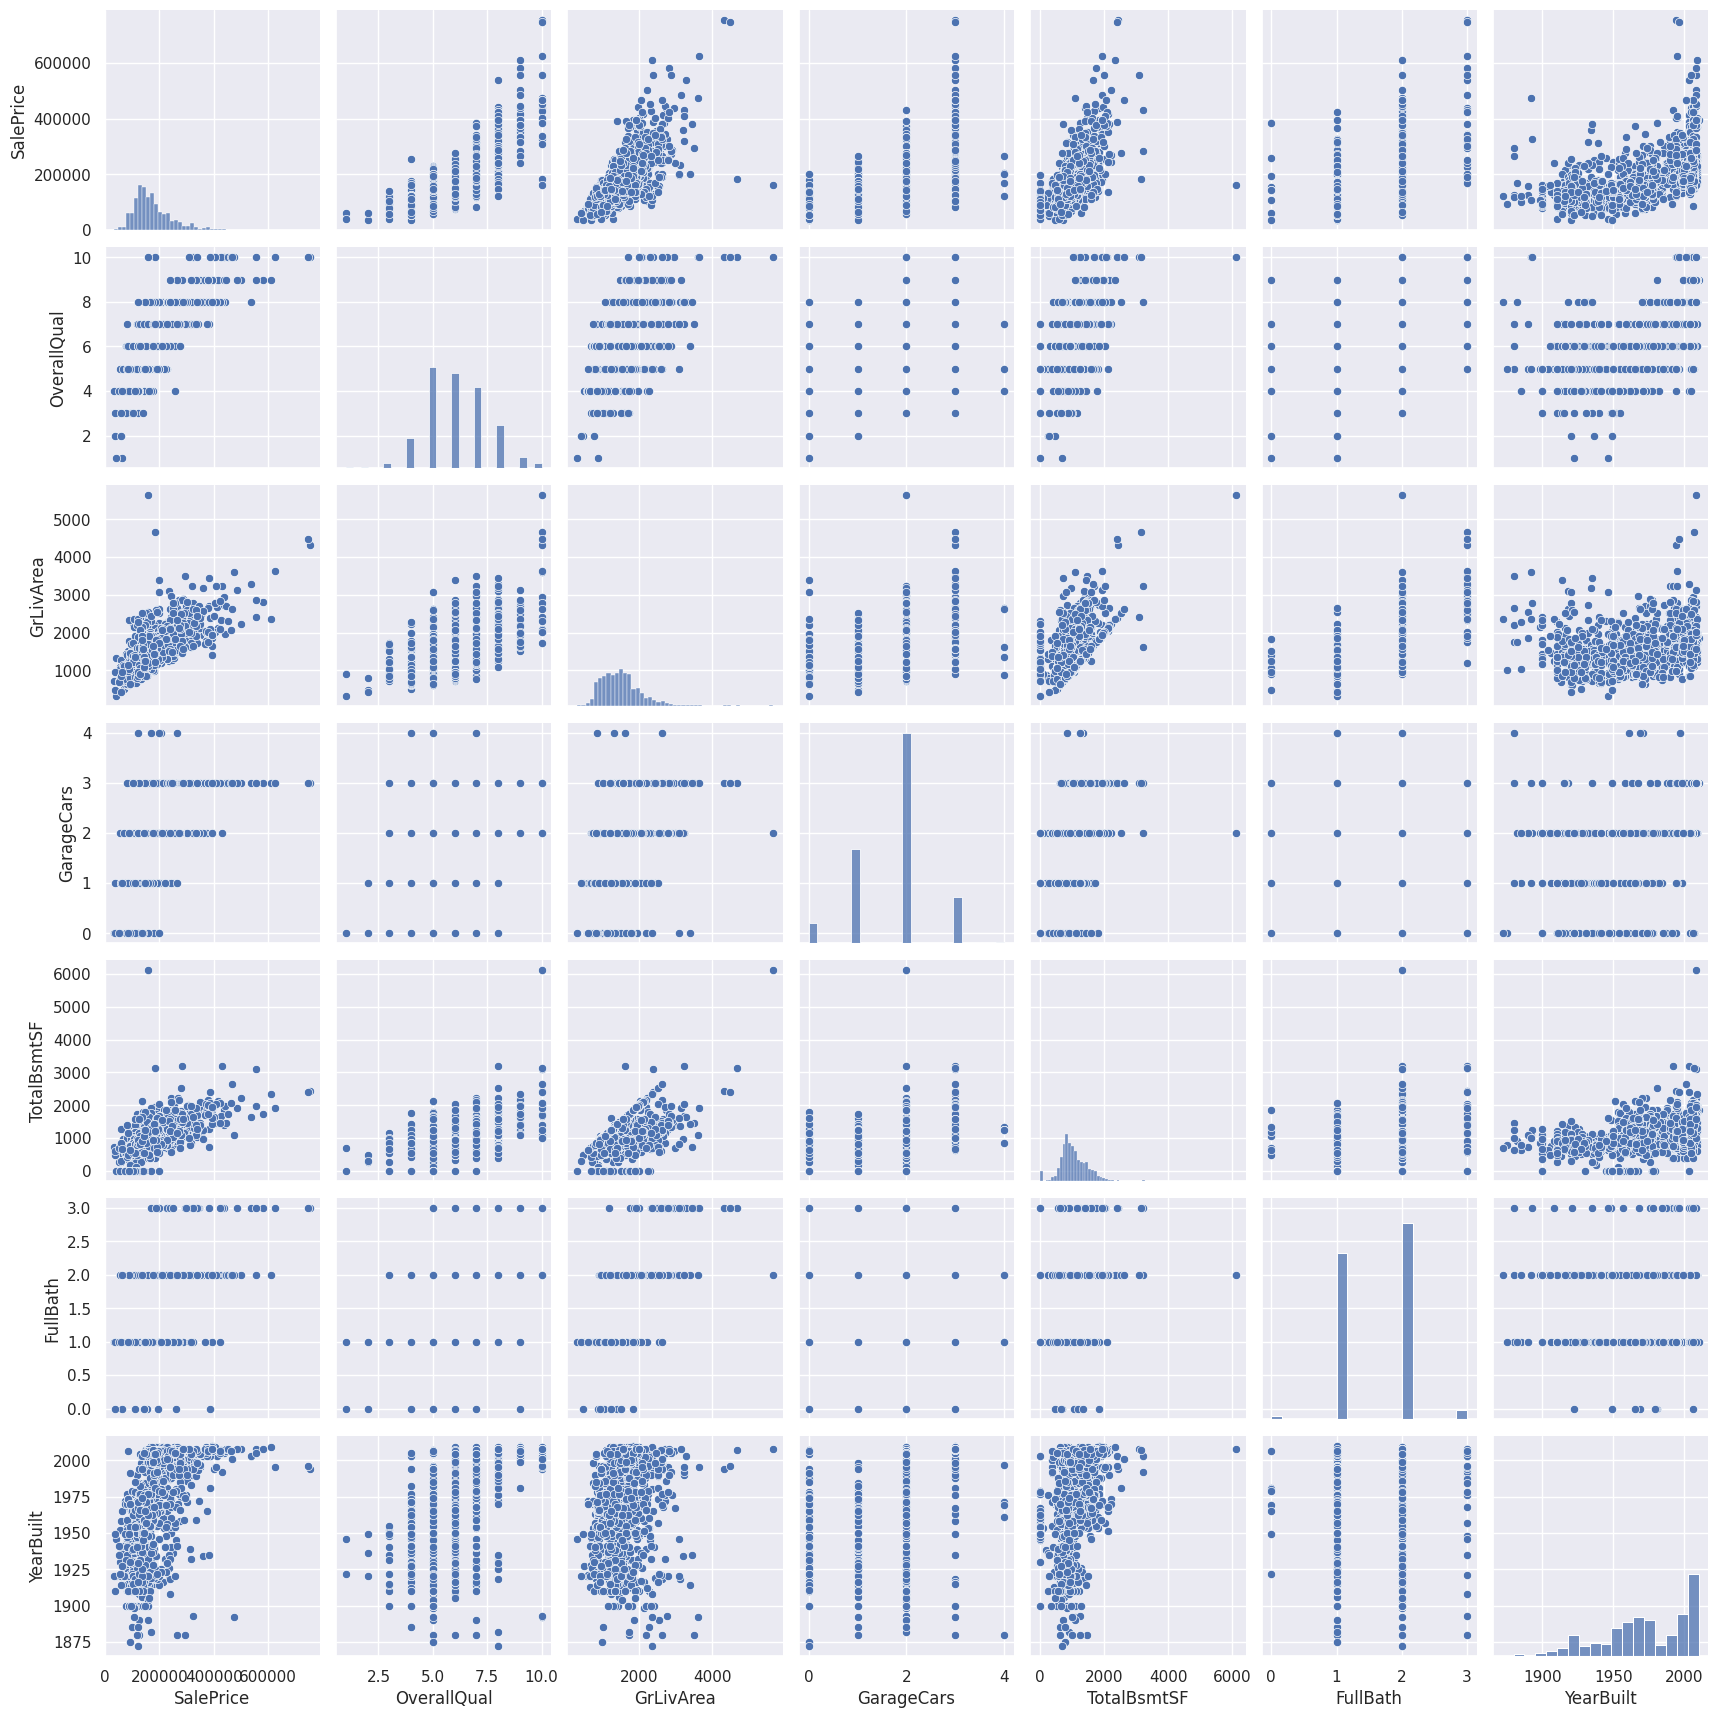

In [45]:
# 산포도
sns.set()  # default set
cols = ['SalePrice', 'OverallQual', 'GrLivArea',
  'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], size = 2.5)
plt.show();

'TotalBsmtSF' and 'GrLiveArea'이 의미 있게 보인다. 산포도를 보면 직선의 한 쪽에 집중해서 나타나는 것을 알 수 있다. 지하실의 크기는 1층의 면적과 거의 같거나 작다.

'YearBuilt'도 약한 지수함수 형태를 보인다. 가격이 계속 오르고 있다.

# 결측치 처리 (Missing Values)

결측 패턴이 산발적인가, 규칙적인가?

In [46]:
df_train.isna().sum()   # the same as isnull()

,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,259
LotArea,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


In [47]:
df_train.count()  # Count non-NA cells for each column or row

,0
Id,1460
MSSubClass,1460
MSZoning,1460
LotFrontage,1201
LotArea,1460
...,...
MoSold,1460
YrSold,1460
SaleType,1460
SaleCondition,1460


In [49]:
# missing data (아래 코드는 결측치 통계를 찾는 코드이다.)
total = df_train.isnull().sum().sort_values(ascending=False)
total.head(10)

percent = (df_train.isnull().sum()/df_train.shape[0]).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageQual,81,0.055479
GarageFinish,81,0.055479
GarageType,81,0.055479


### 분석 결과
- 결측률이 15% 이상이면 이 특성은 제외하고 분석하는 것이 타당하다.('PoolQC', 'MiscFeature', 'Alley' 등) 이러한 데이터의 중요도도 생각해봐야 한다.

- 'Garage*X*'의 결측치 비율이 같고, 중복성이 있다.'Bsmt*X*' 특성도 마찬가지

- 'MasVnrArea' and 'MasVnrType'는'YearBuilt'나 'OverallQual' 와 상관과계가 크므로 중복성이 있어 제외 가능하다.

- 'Electrical'는 한 값만 결측이므로 해당 샘플만 제거한다.

- 'Electrical' 외의 결측치를 관찰한 결과 모두 특성에서 제외하기로 한다.

In [50]:
df_train_org = df_train.copy()    # 만일을 위해서 (나중에 비교해 볼 필요가 있을때)

In [51]:
df_train = df_train.drop(missing_data[missing_data['Total'] > 1].index, axis=1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

df_train.isnull().sum().max()            # null 합의 최고가 0 인지 확인

0

In [52]:
df_train_org.shape, df_train.shape    # 18 개 columns , 1 row 제거

((1460, 81), (1459, 63))

# 특이값(outlier) 처리

중요한 의미나 정보를 포함할 수 있다. 표준편차나 산포도에서 찾을 수 있다.

표준 정규화를 하여 비교한다. 상위 영역에 7 이상의 표준편차 차이가 있는 것을 알 수 있다.

#### uni-variable 분석 (target variable)

In [53]:
saleprice_scaled = StandardScaler().fit_transform(np.array(df_train['SalePrice']).reshape(-1,1))
saleprice_scaled

array([[ 0.34704187],
       [ 0.0071701 ],
       [ 0.53585953],
       ...,
       [ 1.07713679],
       [-0.48847623],
       [-0.42081658]])

In [54]:
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]

print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


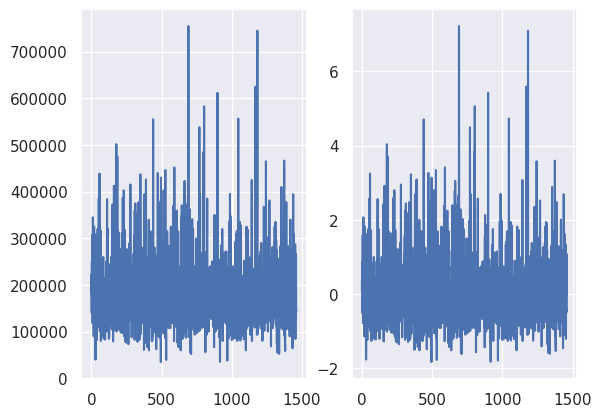

In [55]:
plt.subplot(1,2,1)
plt.plot(df_train['SalePrice'])   # if not shown, x-axis is default len(y)
plt.subplot(1,2,2)
plt.plot(saleprice_scaled)

### Bivariate 분석

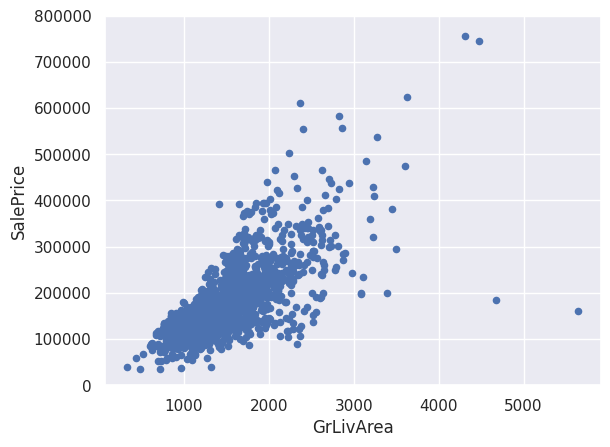

In [56]:
# bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)

data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

우측의 두 점은 트렌드를 따르지 않는 값으로 여기서는 삭제한다. 상위의 두 점은 7~ 값을 갖는 케이스인데 트렌드를 따르므로 삭제하지 않는다.

In [57]:
# deleting points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [58]:
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

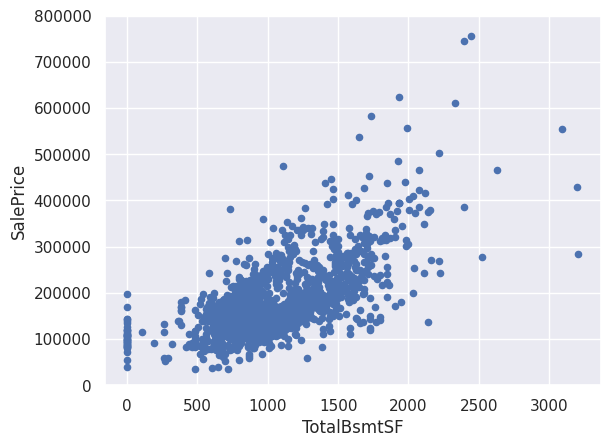

In [59]:
# bivariate analysis saleprice/TotalBsmtSF
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

우측의 이상치가 있어 보이지만 전체적인 추세를 따르므로 그대로 둔다.

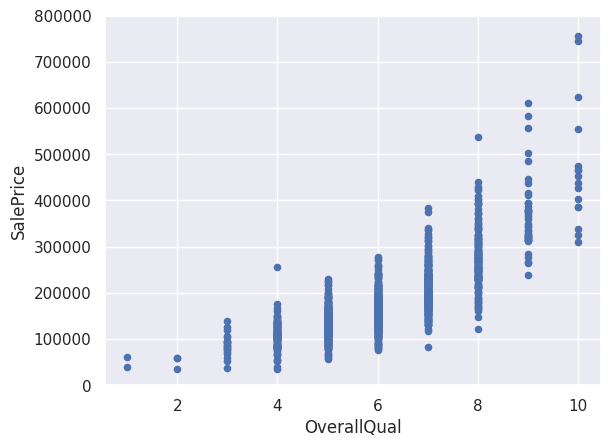

In [60]:
# bivariate analysis saleprice/overallqual
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

# 분포 확인

점검할 사항:

- 정규성: 일반적으로 더 좋은 성능 기대 (특히, 선형 모델)
- 등분산성

### In the search for normality

- 히스토그램: Kurtosis and skewness (첨도 및 왜도) 점검
- Normal probability plot

- 'SalePrice'는 정규분포는 아니다. 정점(peakedness)이 존재하고 양의 왜곡(positive skewness)를 보인다. 양의 왜곡에는 로그 변환을 하면 도움이 된다.

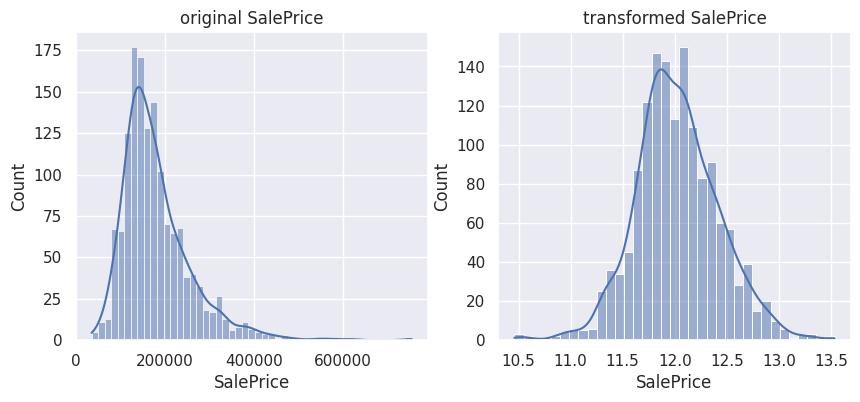

In [61]:
# 히스토그램과 정규분포 플롯
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df_train['SalePrice'], kde=True);  #  plot the estimated PDF over the data.
plt.title('original SalePrice')

# 로그변환
plt.subplot(1,2,2)

sns.histplot(np.log(df_train['SalePrice']), kde=True);
plt.title('transformed SalePrice')

plt.show()

In [62]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

- 'GrLivArea'에 대해서 알아보겠다.

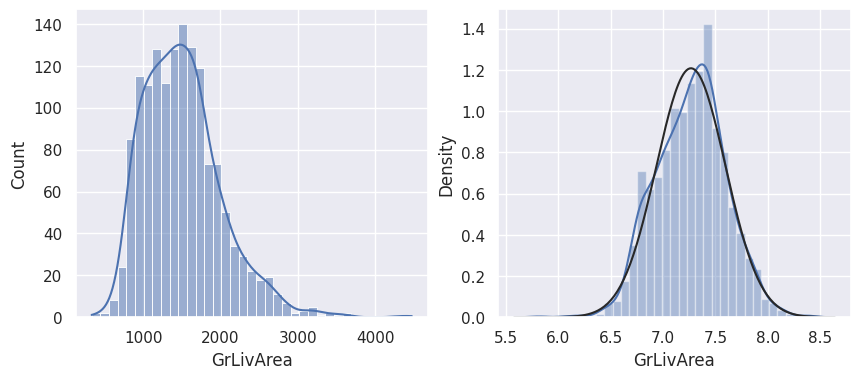

In [63]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df_train['GrLivArea'], kde=True, );
plt.subplot(1,2,2)
sns.distplot(np.log(df_train['GrLivArea']), fit=norm);

In [64]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

- TotalBsmtSF 변수에 대한 그래프

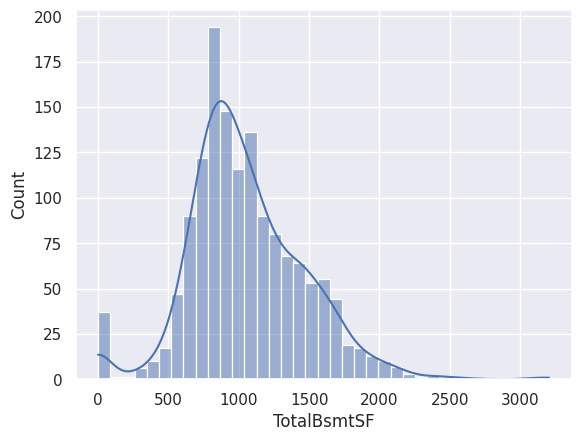

<Figure size 640x480 with 0 Axes>

In [65]:
sns.histplot(df_train['TotalBsmtSF'], kde=True);
fig = plt.figure()

- 값이 0인 것은 로그 변환을 할 수 없다. 0인 경우는 '지하실 없음' 등으로 표현하고 0 이상인 값에 대해서만 로그 변환을 할 수 있다.

In [66]:
# 별도의 컬럼 추가
# area>0 이면 1, for area==0 이면 0
df_train['HasBsmt'] = 0
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1
df_train['HasBsmt'].head(5)

,HasBsmt
0,1
1,1
2,1
3,1
4,1


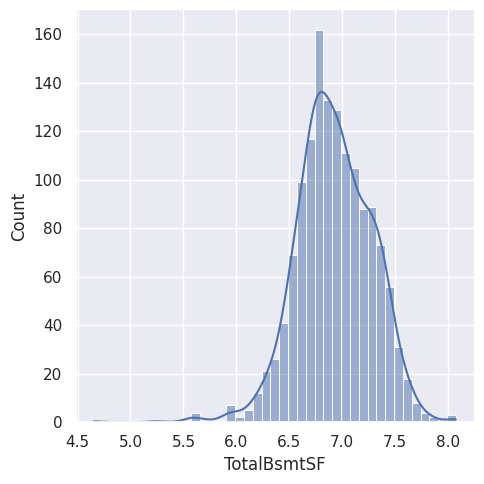

<Figure size 640x480 with 0 Axes>

In [67]:
# 양수인 경우 로그 변환
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])
# 히스토그램
sns.displot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], kde=True);
fig = plt.figure()

### homoscedasticity (등분산)
- Homoscedasticity(or homogeneity of variances): 분산이 일정하다는 가정
- 주로 선형 회귀와 같은 선형 모델에서 중요한 가정. 선형 모델은 오차가 일정한 분산을 가지고 있다는 가정하에 작동하므로, 이 가정이 깨지면 예측 성능과 해석의 신뢰성이 떨어질 수 있다.
-  비선형 모델이나 더 복잡한 머신러닝 모델(예: 랜덤 포레스트, 그래디언트 부스팅, 신경망 등)에서는 크게 작용하지 않는다.
- 산포도로 확인할 수 있다.

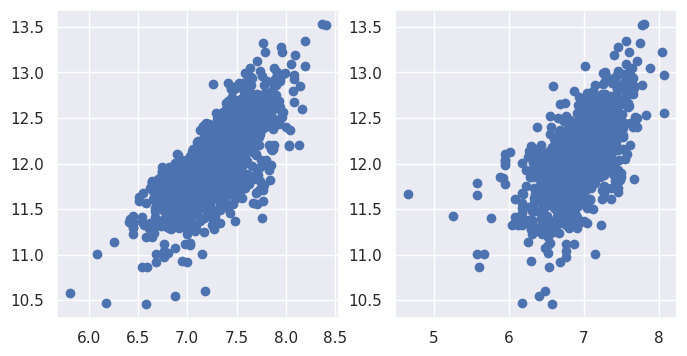

In [68]:
# scatter plot
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(df_train['GrLivArea'], df_train['SalePrice']);
plt.subplot(1,2,2)
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'],
            df_train[df_train['TotalBsmtSF']>0]['SalePrice']);

# 머신러닝 모델 적용
* General Order
  - Decide Features (Conceptual): During the exploratory data analysis, decide on the important features and any new features you want to create (this is before setting up the pipeline).
  - Handling Missing values and Outliers: Impute or remove
  - Train-test split: ensures that transformations, augmentations, and feature engineering steps do not affect the test set.
  - Transformations: apply Log transform if needed, for skewed features (or target). It should be done before scaling (because log transforms can drastically change the scale of features.)
  - Categorical encoding: one-hot encoding does not need scaling.
  - Feature Scaling
  - SMOTE (if needed, for imbalanced datasets)

In [69]:
# features collected
df_train = df_train_org.copy()

# missing data
total = df_train.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
df_train = df_train.drop(missing_data[missing_data['Total'] > 1].index, axis=1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

# outlier
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

# log transform
df_train['SalePrice'] = np.log(df_train['SalePrice'])
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

# log transform only on positive numbered samples
df_train['HasBsmt'] = 0
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

In [70]:
df_train_org.shape, df_train.shape, df_train.dtypes

((1460, 81),
 (1457, 64),
 Id                 int64
 MSSubClass         int64
 MSZoning          object
 LotArea            int64
 Street            object
                   ...   
 YrSold             int64
 SaleType          object
 SaleCondition     object
 SalePrice        float64
 HasBsmt            int64
 Length: 64, dtype: object)

### using 4 numeric features


- before preprocessing

In [72]:
### use 4 numeric columns only - original data

from sklearn.linear_model import LinearRegression,  SGDRegressor
from sklearn.model_selection import train_test_split

np.random.seed(42)
df = df_train_org.copy()

# choose features
corrmat = df.corr(numeric_only=True)   # changed as of pandas 1.5.0
cols = corrmat.nlargest(5, 'SalePrice')

df = df[cols.index]
print(f'Feaures to use: {cols.index}')
print(f'Number of missing values: {df[cols.index].isnull().sum().sum()}')

X, y = df.values[:,1:], df.values[:,0]    # y is in the first column

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# model
model = LinearRegression()
model.fit(X_train, y_train)
print("X data shapes (train and test): ", X_train.shape, X_test.shape)
print("Performance before preprocessing: ",
      model.score(X_train, y_train),
      model.score(X_test, y_test))

Feaures to use: Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea'], dtype='object')
Number of missing values: 0
X data shapes (train and test):  (1168, 4) (292, 4)
Performance before preprocessing:  0.734066796961067 0.762493362235422


- after preprocessing

In [74]:
# features collected
df_train = df_train_org.copy()
np.random.seed(42)

# missing data
total = df_train.isnull().sum().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
df_train = df_train.drop(missing_data[missing_data['Total'] > 1].index, axis=1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

# outlier
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

# log transform
df_train['SalePrice'] = np.log(df_train['SalePrice'])
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

# log transform only on positive numbered samples
df_train['HasBsmt'] = 0
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1
df_train.loc[df_train['HasBsmt']==1,'TotalBsmtSF'] = np.log(df_train['TotalBsmtSF'])

In [75]:
### use 4 numeric columns only - preprocessed data
np.random.seed(42)
df = df_train.copy()
cols = df.corr(numeric_only=True).nlargest(5, 'SalePrice')
df = df[cols.index]

X, y = df.values[:,1:], df.values[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# transform
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# model
model = LinearRegression()
model.fit(X_train_sc, y_train)
print("X data shapes (train and test): ", X_train_sc.shape, X_test_sc.shape)
print("Performance before preprocessing: ",
      model.score(X_train_sc, y_train),
      model.score(X_test_sc, y_test))

X data shapes (train and test):  (1165, 4) (292, 4)
Performance before preprocessing:  0.7951741021410275 0.8173995324627059


- much better!

# 모두 사용:
- 범주형 피처는 LabelEncoding(), OrdinalEncoding(), or OneHotEncoding()
- 일반적인 순서:
  - 결측치 처리 → 범주형 인코딩 → 수치형 스케일링 → 모델 학습

In [77]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

np.random.seed(42)
df = df_train.copy()   # pre-processed

# features to use
df = df.drop(['Id', 'HasBsmt'], axis=1)

# split
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(X, y, test_size=0.2)

# categorical encoding: string 인 column 은 모두 OrdinalEncoder
# 만약에 test set 에 train 에 없던 값이 나타나면 -1 (unseen value).
encoders = {}
for i in range(len(X_df_train.dtypes)):
    if X_df_train.dtypes[i] == 'object':
        # -1 will be used for unseen values.
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

        # Reshape is needed for OrdinalEncoder
        encoded_values = encoder.fit_transform(X_df_train.iloc[:,i].values.reshape(-1, 1))

        # Assign the transformed values back to the DataFrame (flatten to 1D)
        X_df_train.iloc[:, i] = encoded_values.flatten()

        encoders[i] = encoder

for i in range(len(X_df_test.dtypes)):
    if i in encoders:  # Check if the column was encoded in the training set
        encoded_values = encoders[i].transform(X_df_test.iloc[:, i].values.reshape(-1, 1))
        # Assign the transformed values back to the test DataFrame (flatten to 1D)
        X_df_test.iloc[:, i] = encoded_values.flatten()

# scaling
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_df_train)
X_test_sc = sc.transform(X_df_test)

# model
model = LinearRegression()
model.fit(X_train_sc, y_train)
print("Using all the featurs: ",
      model.score(X_train_sc, y_train),
      model.score(X_test_sc, y_test))

Using all the featurs:  0.9199642560678148 0.9091091182280986


- even better!

# Exercise

### new axis

In [ ]:
# exercise: newaxis (축을 새로 추가하기)
import numpy as np
x = np.array([1,2,3,4])
print(x, x.shape)
print(x[:,np.newaxis].shape)   # (4,) -> (4,1), x.reshape(4,1) 와 동일
print(x[np.newaxis,:].shape)  #  x.reshape(1,4) 와 동일

[1 2 3 4] (4,)
(4, 1)
(1, 4)


### skewness, kurtosis
- df.kurtosis() returns an excess kurtosis, a value related to the distribution's "tailedness" compared to a normal distribution, with a value of 0 for a normal distribution.

0   -0.015316
dtype: float64 0   -0.045898
dtype: float64


<Axes: ylabel='Density'>

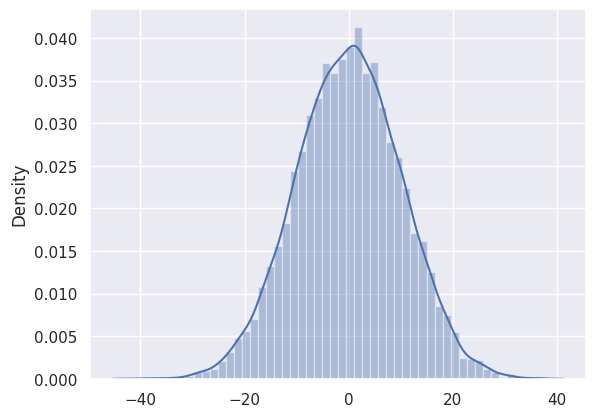

In [ ]:
sample_df = pd.DataFrame(10*np.random.randn(10000,1))
sample_df.head()
print(sample_df.skew(), sample_df.kurtosis())   # excess kurtosis = kurtosis -3
sns.distplot(sample_df, color='b')

- kurtosis(첨도): b=3 정규분포, b>3 뾰족함, b<3 평평함
- skewness(왜도): a=0 정규분포, a>0 좌측치우침, a<0 우측치우침
- excess kurtosis (초과왜도): defined as kurtosis -3
- Note: The only data values (observed or observable) that contribute to kurtosis in
  any meaningful way are those outside the region of the peak; i.e., the outliers.
  Therefore, kurtosis measures outliers only; it measures nothing about the "peak".

### print in Python

In [ ]:
# 1. 포맷 문자열 (f-문자열)
table = {'Sjoerd': 4127, 'Jack': 4098, 'Dcab': 7678}
# table.items()              # dict.items(), dict.keys(), dict.values()
for name, phone in table.items():
    print(f'{name:7s} ==> {phone:7d}')

Sjoerd  ==>    4127
Jack    ==>    4098
Dcab    ==>    7678


In [ ]:
# 2. 문자열 format 메쏘드
print('The story of {1}, {0}, and {other}.'.format('Bill', 'Manfred', other='Georg'))

The story of Manfred, Bill, and Georg.


In [ ]:
# 3. 예전의 문자열 포맷팅 (use %) - sprintf() 스타일
print('%(language)s has %(number)03d quote types.' % {'language': "Python", "number": 2})

Python has 002 quote types.


### Correlation
- np.corrcoef() and df.corr()
- df.corr() is NaN tolerant whereas np.corrcoef is not.

In [ ]:
a = np.array([1, 2, 3, 4, 5, np.nan])
b = np.array([2, 3, 4, 5.25, np.nan, 100])
print(np.corrcoef(a,b))
# ----
print(np.ma.masked_invalid(a),np.ma.masked_invalid(b))
np.ma.corrcoef(np.ma.masked_invalid(a), np.ma.masked_invalid(b))

[[nan nan]
 [nan nan]]
[1.0 2.0 3.0 4.0 5.0 --] [2.0 3.0 4.0 5.25 -- 100.0]


masked_array(
  data=[[1.0, 0.99838143945703],
        [0.99838143945703, 1.0]],
  mask=[[False, False],
        [False, False]],
  fill_value=1e+20)

In [ ]:
a = np.array([1, 2, 3, 4, 5, np.nan])
b = np.array([2, 3, 4, 5.25, np.nan, 100])
df = pd.concat([pd.DataFrame(a), pd.DataFrame(b)], axis=1)
df.corr()

,0,0
0,1.000000,0.998381
0,0.998381,1.000000


### something about pandas and numpy

- NaN is a numeric value, as defined in IEEE 754 floating-point standard.
- None is an internal Python type (NoneType) and would be more like "inexistent" or "empty" than "numerically invalid" in this context.
- if you compute something including nan, you will get nan. But, you can not compute None.

In [78]:
np.nan + 2

nan

In [79]:
None + 2

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [80]:
x = None        # nothing, empty, null

if x:
  print("Do you think None is True?")
elif x is False:
  print ("Do you think None is False?")
else:
  print("None is not True, or False, None is just None...")

None is not True, or False, None is just None...


In [ ]:
x = np.nan       # nothing, empty, null

if x:
    print("Do you think None is True?")
else:
    pass

Do you think None is True?


In [ ]:
df = pd.DataFrame([[1,2,3],[None, None, 1]])    # np.nan 와 동일
df

,0,1,2
0,1.0,2.0,3
1,NaN,NaN,1


In [ ]:
array = np.array([[1, np.nan, 3],
                  [4, 5, np.nan]])
pd.DataFrame(array)

,0,1,2
0,1.0,NaN,3.0
1,4.0,5.0,NaN


In [ ]:
print(pd.isna(array))
print(pd.isna(array[0]))

[[False  True False]
 [False False  True]]
[False  True False]


In [ ]:
df = pd.DataFrame([['ant', 'bee', 'cat'],
                   ['dog', 'cat' , 'fly']], columns=['A','B','C'])
df

,A,B,C
0,ant,bee,cat
1,dog,cat,fly


In [ ]:
df['A']           # column name 0 (feature), not a row index (index)

,A
0,ant
1,dog


In [ ]:
df[['A','B']]

,A,B
0,ant,bee
1,dog,cat


In [ ]:
df[:1] == df.iloc[:1]

,A,B,C
0,True,True,True


In [ ]:
df['B'] == 'cat'

,B
0,False
1,True


In [ ]:
df[df['B'] == 'cat']['A']

,A
1,dog


In [ ]:
df.loc[df['B'] == 'cat','A']

,A
1,dog
